# Edge detedction

Edge detection solutions to road lane markings involve several steps  
1. Smoothing to reduce noise  
2. Edge detection  
3. Filtering edges  
3. Comparison to ground truth  


There are varoius methods of edge detection and this notebook will compare the performance of  [Canny Edge Detection](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.420.3300&rep=rep1&type=pdf) to a Laplacian of Gaussians approach, inspired by [Marr and Hildreth's](https://royalsocietypublishing.org/doi/10.1098/rspb.1980.0020) approach. Diference of Gaussians is an approximation to Laplacian of Gaussians, and for that reason I will not investigate it.


Furthermore filtering edges can thresholding and applying prior knowledge of the types of edges we want to detect (geometric shape, length, place on picture).  


Visual comparisons will be emphasized to build intuition for the effect of each step
- appropriate cutoff ranges
- robustness of outcome to parameter value
- computational bottle necks


This is important when tuning these parameters in an automated manner (without visual inspection). A hand crafted approach, such as edge detection, has the advantage that the "black-box" can be opened up and each parameter can played with, visualizations can be made at each step. This notebook is meant to help build an overall intuition for the algorithm.

# Compute environment
With the help of David Quispe, I managed to find a way to use google's collaboratory notebooks and mount my Google Drive account. Colab notebooks have an impresive compute and disk quotas and are free.

In [0]:
!nvcc --version # cuda 10

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!df -h # hundreds of G of disk

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   23G  318G   7% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1       365G   27G  339G   8% /opt/bin
tmpfs           6.4G   12K  6.4G   1% /var/colab
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   15G  961M  94% /content/drive


In [0]:
!free -mh #12G of RAM

              total        used        free      shared  buff/cache   available
Mem:            12G        475M         10G        908K        1.9G         11G
Swap:            0B          0B          0B


In [0]:
!nvidia-smi # 12 G Tesla K80 GPU. These cost about $5000!

Thu Mar 21 15:12:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import image

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
import glob
wdir = '/content/drive/My Drive/ece1512/homework/3/'
image_dir =  wdir+'bdd100k/images/10k/\
train/'
fname_list = glob.glob(image_dir+'*jpg')
len(fname_list)

7000

In [0]:
import cv2
img = cv2.imread(fname_list[2])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


Text(0.5, 1.0, 'Original image, converted to gray scale')

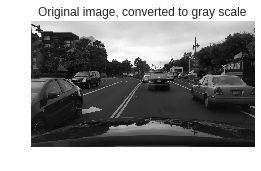

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
plt.imshow(gray,cmap='gray')
plt.axis('off')
plt.title('Original image, converted to gray scale')

## Noise reduction
Edge detection by using small kernels that detect changes in derivatives are sensitive to noise. This is discussed at length in Gonzales and Woods, Chapter 10. The figures that show the sensitivity of the second derivatives to noise are particularly dramatic. 

One way to reduce noise is by spatial blurring. This method also blurs the edge, but in practice the noise reduction is worth it. A simple method is gaussian filtering. Below we'll compare two methods (1) a custom made kernel and (2) `scipy.ndimage.gaussian_filter`

In [0]:
import numpy as np
import scipy.signal
import time

def gaussian_kernel(size, sigma):
  '''credit: https://towardsdatascience.com/
  canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123'''
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

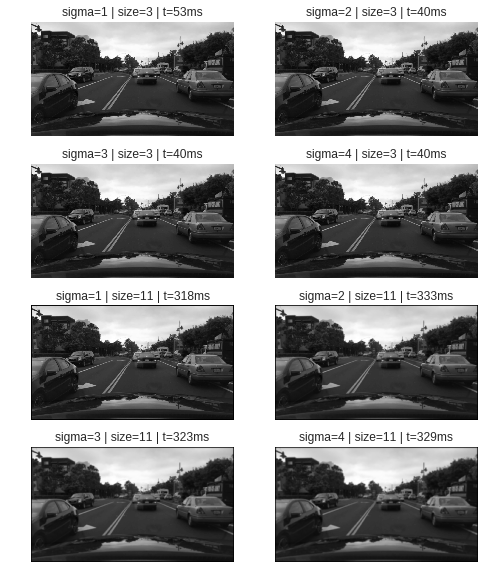

In [0]:

  
scale=20
R,C=np.array(gray.shape) / max(gray.shape)
fig = plt.figure(figsize=(8,10))  
sizes= [3,11]
sigmas=[1,2,3,4]
I,J = len(sizes),len(sigmas)
idx=1
for i,size in enumerate(sizes):
  for j,sigma in enumerate(sigmas):
    g = gaussian_kernel(size, sigma)
    s = time.time()
    smooth = scipy.signal.convolve2d(gray,g)
    e = time.time()
    plt.subplot(J,I,idx)
    plt.imshow(smooth,cmap='gray')
    plt.title('sigma=%i | size=%i | t=%ims' % (sigma,size,1e3*(e-s)))
    plt.axis('off')
    idx+=1

  

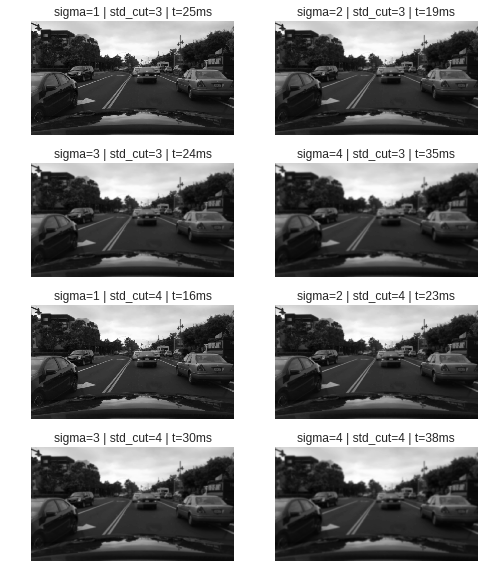

In [0]:
scale=20
R,C=np.array(gray.shape) / max(gray.shape)
fig = plt.figure(figsize=(8,10))#figsize=(C*scale,R*scale))  
truncations= [3,4]
sigmas=[1,2,3,4]
I,J = len(truncations),len(sigmas)
idx=1
for i,truncate in enumerate(truncations):
  for j,sigma in enumerate(sigmas):
    s = time.time()
    smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)
    e = time.time()
    plt.subplot(J,I,idx)
    plt.imshow(smooth,cmap='gray')
    plt.title('sigma=%i | std_cut=%i | t=%ims' % (sigma,truncate,1e3*(e-s)))
    plt.axis('off')
    idx+=1



Unsurprisingly, `scipy.ndimage.gaussian_filter` is faster. We can visualize a given kernel from `gaussian_kernel`, but its not immediately clear to me how to do this from .`scipy.ndimage.gaussian_filter`. However, the important thing is to see how the different smoothness result in different edges being detected.

(-0.5, 10.5, 10.5, -0.5)

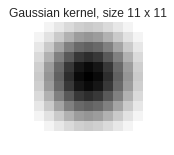

In [0]:
fig = plt.figure(figsize=(2,2))  
plt.imshow(g)
plt.title('Gaussian kernel, size %i x %i' % g.shape)
plt.axis('off')

## Bilateral filter
The bilaterial filter removes noise, but does not blur the iamge like a Gaussian filter does. See the webpage [Bilateral Filtering for Gray and Color Images](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html) and references therein for more explanation. For now, note that:

> *Gaussian low-pass filtering computes a weighted average of pixel values in the neighborhood, in which the weights decrease with distance from the neighborhood center. Although formal and quantitative explanations of this weight fall-off can be given, the intuition is that images typically vary slowly over space, so near pixels are likely to have similar values, and it is therefore appropriate to average them together. The noise values that corrupt these nearby pixels are mutually less correlated than the signal values, so noise is averaged away while signal is preserved. The assumption of slow spatial variations fails at edges, which are consequently blurred by linear low-pass filtering. How can we prevent averaging across edges, while still averaging within smooth regions? Many efforts have been devoted to reducing this undesired effect. Bilateral filtering is a simple, non-iterative scheme for edge-preserving smoothing.* (Bilateral Filtering for Gray and Color Images)

Although it is hard (for me personally) to distinguish the different bilaterally filtered images below, they have an influence on the edge detection. We use `cv2.canny` below and go into more detail in the next section about this method.



### Gray scale image

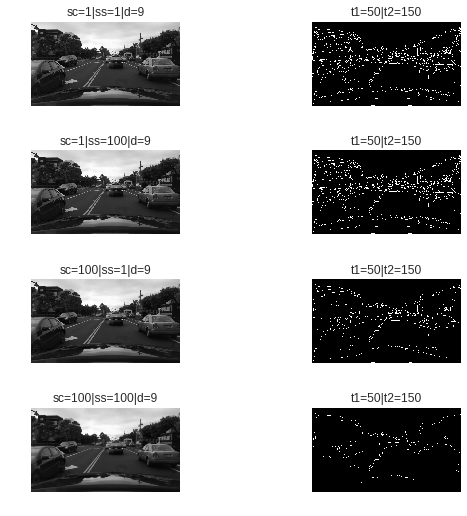

In [0]:
fig = plt.figure(figsize=(8.5,11/1.5))
sigmaColors= [1,100]
sigmaSpaces=sigmaColors
ds=[9]
I,J,K = len(sigmaColors),len(sigmaSpaces),len(ds)
idx=1
for i,sigmaColor in enumerate(sigmaColors):
  for j,sigmaSpace in enumerate(sigmaSpaces):
    for k,d in enumerate(ds):
      s = time.time()
      smooth = cv2.bilateralFilter(gray,
                               d=d,
                               sigmaColor=sigmaColor,
                               sigmaSpace=sigmaSpace)
 
      e = time.time()
      plt.subplot(J*I*K,2,idx)
      plt.imshow(smooth,cmap='gray')
      plt.title('sc=%i|ss=%i|d=%i' % (sigmaColor,sigmaSpace,d))
      plt.axis('off')
      
      threshold1=50
      threshold2=150
      edges = cv2.Canny(smooth,
                      threshold1=threshold1, 
                      threshold2=threshold2,
                      apertureSize=3,
                      L2gradient=False)
      plt.subplot(J*I*K,2,idx+1)
      plt.imshow(edges,cmap='gray')
      plt.title('t1=%i|t2=%i' % (threshold1,threshold2))
      plt.axis('off')
      
      idx+=2
    
plt.tight_layout()

### Colour image
OpenCV's bilateral filter `cv2.bilateralFilter` has parameters `sigmaColour` and `sigmaSpace`, so let's look at how it smoothes a colour image. 

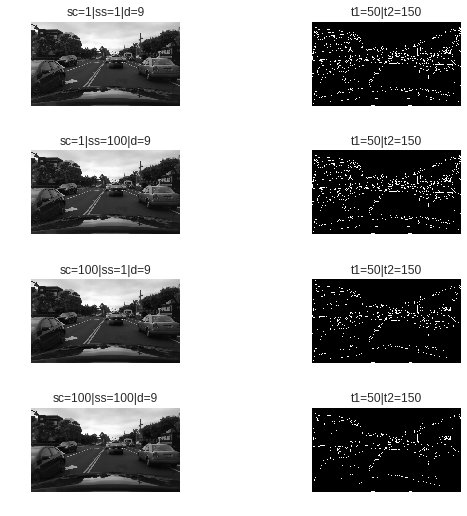

In [0]:
fig = plt.figure(figsize=(8.5,11/1.5))
sigmaColors= [1,100]
sigmaSpaces=sigmaColors
ds=[9]
I,J,K = len(sigmaColors),len(sigmaSpaces),len(ds)
idx=1
for i,sigmaColor in enumerate(sigmaColors):
  for j,sigmaSpace in enumerate(sigmaSpaces):
    for k,d in enumerate(ds):
      smooth = cv2.bilateralFilter(img,
                               d=d,
                               sigmaColor=sigmaColor,
                               sigmaSpace=sigmaSpace)
 
      smooth = cv2.cvtColor(smooth,cv2.COLOR_BGR2GRAY)
      plt.subplot(J*I*K,2,idx)
      plt.imshow(smooth,cmap='gray')
      plt.title('sc=%i|ss=%i|d=%i' % (sigmaColor,sigmaSpace,d))
      plt.axis('off')
      
      threshold1=50
      threshold2=150
      edges = cv2.Canny(smooth,
                      threshold1=threshold1, 
                      threshold2=threshold2,
                      apertureSize=3,
                      L2gradient=False)
      
      plt.subplot(J*I*K,2,idx+1)
      plt.imshow(edges,cmap='gray')
      plt.title('t1=%i|t2=%i' % (threshold1,threshold2))
      plt.axis('off')
      
      idx+=2
    
plt.tight_layout()

The edges are certainly different when we do: 
1. colour  --> gray --> bilateral --> edge detection
2. colour  --> bilateral  -->  gray  --> edge detection 

But at this point I am visually inspecint the edges. Therefore let's turn our attention to tuning the parameters in the Canny edge detection. 

# Canny edge detection
OpenCV includes a method for Canny Edge detection `cv2.Canny`, which we used above to detect edges. Refer to the [documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html) for an explanation of the steps: 1. Noise Reduction, 2. Finding Intensity Gradient of the Image, 3. Non-maximum Suppression, 4. Hysteresis Thresholding

The documentation explains that a Sobel kernel is used to comptue a gradient. It is possible to use other kernels. Below we will look at the effect of using different kernels on Canny edge detection, something not possible with `cv2.Canny`.

## Gradient detection with Sobel filters
We can actually detect quite different edges given the different blurring amounts. Below we plot the detected edges for different amounts of bluring. The Sobel filters do not have any tuneable parameters; this comes later with how the edges are thresholded. The documentation of cv2.Laplacian lists Sobel and Scharr filters. See the aarticle [Prewitt, Sobel and Scharr gradient 5x5 convolution matrices](http://www.hlevkin.com/articles/SobelScharrGradients5x5.pdf) by Guennadi (Henry) Levkine of Vancouver Canada.

In [0]:
from scipy import ndimage

def sobel_filters(img):
  '''credit: https://towardsdatascience.com/
  canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123'''
  Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

  Ix = ndimage.filters.convolve(img.astype(np.float32), Kx)
  Iy = ndimage.filters.convolve(img.astype(np.float32), Ky)

  G = np.hypot(Ix, Iy)
  G = G / G.max() * 255
  theta = np.arctan2(Iy, Ix)

  return (G, theta)

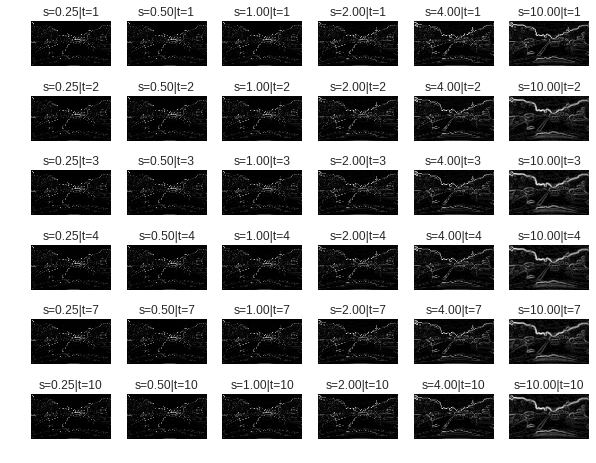

In [0]:
fig = plt.figure(figsize=(10,8))  
truncations= [1,2,3,4,7,10]
sigmas=[0.25,0.5,1,2,4,10]
I,J = len(truncations),len(sigmas)
idx=1
for i,truncate in enumerate(truncations):
  for j,sigma in enumerate(sigmas):
    s = time.time()
    smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)
    G, theta = sobel_filters(smooth)
    e = time.time()
    plt.subplot(I,J,idx)
    plt.imshow(G,cmap='gray')
    plt.title('s=%1.2f|t=%i' % (sigma,truncate))
    plt.axis('off')
    idx+=1



## Non-Maximum Suppression
The final edges depend on smoothing and thresholding. A design goal of Canny edge detection is to have the edges thin, as one pixel. One way to thin out the edges by taking the maximum intensity pixel along the direction of the gradient (ie Non-Maximum Suppression). This method, like the Sobel filters, also has no tuneable parameters.  

NB:  
(1) This type of Non-Maximum Supression is pixel wise and distinct from a common task in object recognition where overlapping boxes are pruned.    
(2) This function has two `for` loops that can be sped up on the GPU using [`numba.guvectorize`](http://numba.pydata.org/numba-doc/0.17.0/reference/compilation.html#numba.guvectorize) . The speedup is from ~10s to ~0.014s (~700x).

In [0]:
import numba

def non_max_suppression_setup(G,theta):
  D = theta
  img = G
  M, N = img.shape
  Z = np.zeros((M,N), dtype=np.float64)
  angle = theta * 180. / np.pi
  angle[angle < 0] += 180
  return(img,angle,M,N,Z)
  

@numba.guvectorize(["void(float64[:,:], float64[:,:],float64[:,:])"],
                   "(m,n),(m,n)->(m,n)",nopython=True)
def non_max_suppression(img,angle,Z):
  '''credit: https://towardsdatascience.com/
  canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123'''
  M,N = img.shape
  for i in range(1,M-1):
    for j in range(1,N-1):
      q = 255
      r = 255

     #angle 0
      if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
        q = img[i, j+1]
        r = img[i, j-1]
      #angle 45
      elif (22.5 <= angle[i,j] < 67.5):
        q = img[i+1, j-1]
        r = img[i-1, j+1]
      #angle 90
      elif (67.5 <= angle[i,j] < 112.5):
        q = img[i+1, j]
        r = img[i-1, j]
      #angle 135
      elif (112.5 <= angle[i,j] < 157.5):
        q = img[i-1, j-1]
        r = img[i+1, j+1]

      if (img[i,j] >= q) and (img[i,j] >= r):
        Z[i,j] = img[i,j]
      else:
        Z[i,j] = 0.

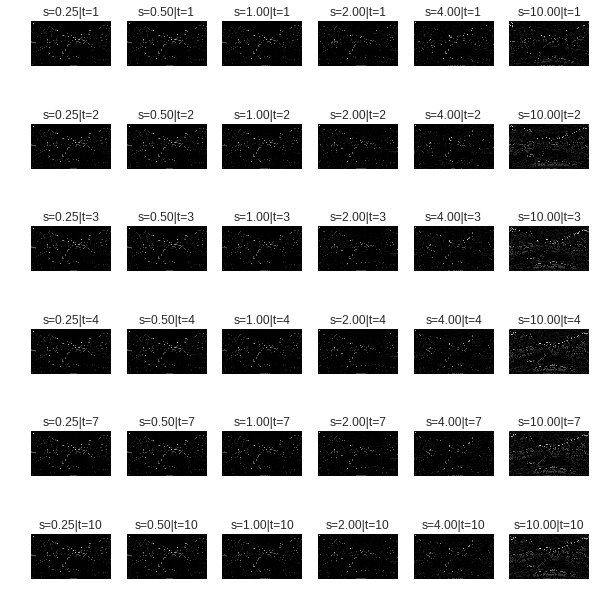

In [0]:


scale=20
R,C=np.array(gray.shape) / max(gray.shape)
fig = plt.figure(figsize=(10,11))  
truncations= [1,2,3,4,7,10]
sigmas=[0.25,0.5,1,2,4,10]
I,J = len(truncations),len(sigmas)
idx=1
for i,truncate in enumerate(truncations):
  for j,sigma in enumerate(sigmas):
    s = time.time()
    smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)
    G, theta = sobel_filters(smooth)
    img,angle,M,N,Z=non_max_suppression_setup(G,theta)
    nms = non_max_suppression(img.astype(np.float64),
                              angle.astype(np.float64),
                              Z.astype(np.float64)
                             )
    e = time.time()
    plt.subplot(I,J,idx)
    plt.imshow(nms,cmap='gray')
    plt.title('s=%1.2f|t=%i' % (sigma,truncate))
    plt.axis('off')
    idx+=1
    


### Benchmarking
The run times are given below.

In [0]:
sigma=1
truncate=4
%time smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)

CPU times: user 17.5 ms, sys: 872 µs, total: 18.4 ms
Wall time: 22.5 ms


In [0]:
%time G, theta = sobel_filters(smooth)

CPU times: user 64.4 ms, sys: 1.32 ms, total: 65.8 ms
Wall time: 66.8 ms


In [0]:
%time img,angle,M,N,Z=non_max_suppression_setup(G,theta)

CPU times: user 6.7 ms, sys: 1.8 ms, total: 8.5 ms
Wall time: 8.7 ms


In [0]:
%time nms = non_max_suppression(img.astype(np.float64),
                                angle.astype(np.float64),
                                Z.astype(np.float64))

CPU times: user 9.55 ms, sys: 11 ms, total: 20.6 ms
Wall time: 20.6 ms


## Thresholding
Both the Sobel filter and Non-Maximum Supression had no tuneable parameters. The next thresholding step does. In fact, there are two, hence this step is called "Double Thresholding". The goal is to identify strong, weak and irrelevant pixels.

One option is to use intensity values for the threshold. However, we can also use ratios. I suspect that this choice will give different behaviour for images that are dark (night images), which are indeed included in the dataset.

(-0.5, 1279.5, 719.5, -0.5)

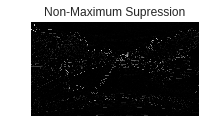

In [12]:
fig = plt.figure(figsize=(3,3))  
sigma=1
truncate=4
smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)
G, theta = sobel_filters(smooth)
img,angle,M,N,Z=non_max_suppression_setup(G,theta)
nms = non_max_suppression(img.astype(np.float64),
                          angle.astype(np.float64),
                          Z.astype(np.float64))
plt.imshow(nms,cmap='gray')
plt.title('Non-Maximum Supression')
plt.axis('off')



In [0]:
def threshold(img, lowThresholdRatio=0.05, 
              highThresholdRatio=0.09,
              strong=np.int32(255),
              weak=np.int32(25)):
  '''credit: https://towardsdatascience.com/
  canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123'''

  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;

  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)

  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)

  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak

  return (res, weak, strong)

Text(0.5, 1.0, 'Double thresholding')

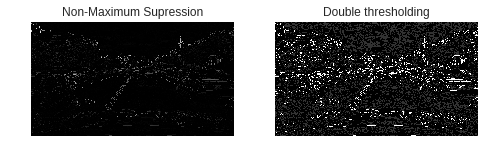

In [0]:
fig,ax = plt.subplots()

thresh,weak,strong = threshold(nms, 
                               lowThresholdRatio=0.05, 
                               highThresholdRatio=0.09,
                               strong=np.int32(255),
                               weak=np.int32(50))

plt.subplot(121)
plt.imshow(nms,cmap='gray')
plt.axis('off')
plt.title('Non-Maximum Supression')

plt.subplot(122)
plt.imshow(thresh,cmap='gray')
plt.axis('off')
plt.title('Double thresholding')



Text(0.5, 0, 'Intensity')

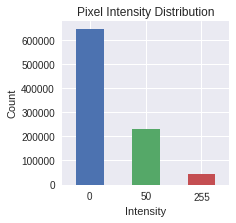

In [0]:
import pandas as pd

fig = plt.figure(figsize=(3,3))
ax=pd.Series(thresh.flatten()).value_counts().plot(
  title='Pixel Intensity Distribution',
  kind='bar',
  rot=True)

plt.ylabel('Count')
plt.xlabel('Intensity')

## Hysteresis
Now the image has three values, 0 for irrelevant pixels, and the params `weak` and `strong` for the given threshold ratios in the `threshold` function. Exactly how we treat the weak pixels depends on its neighbourhood. The criterion is quite simple. Weak becomes strong iff one or more pixels in its neighbourhood is strong. The function below defines neghbourhood as the immediate neighbour, but perhaps this could be extended to larger windows. However, without this, there are no tuning parameters in hysteresis.

In [0]:
def hysteresis_setup(thresh,strong,weak):
  hys = np.zeros_like(thresh)
  M=hys.shape[0]
  weak=weak*np.ones(M)
  strong=strong*np.ones(M)
  return(strong,weak,hys)
  

@numba.guvectorize(["void(int16[:,:],int16[:],int16[:],int16[:,:])"],
                   "(m,n),(m),(m)->(m,n)",nopython=True)
def hysteresis(img, strong_vec,weak_vec,hys ):
  '''credit: https://towardsdatascience.com/
  canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123'''
  strong=strong_vec[0]
  weak=weak_vec[0]
  M, N = img.shape
  #hys = img
  for i in range(1, M-1):
    for j in range(1, N-1):
      if (img[i,j] == weak):
        if ((   img[i+1, j-1] == strong) or (img[i+1, j  ] == strong) 
            or (img[i+1, j+1] == strong) or (img[i  , j-1] == strong) 
            or (img[i  , j+1] == strong) or (img[i-1, j-1] == strong) 
            or (img[i-1, j  ] == strong) or (img[i-1, j+1] == strong)):
          hys[i, j] = strong
        else:
          hys[i, j] = 0
      elif (img[i,j] == strong):
        hys[i, j] = img[i,j]

thresh,weak,strong = threshold(nms, lowThresholdRatio=0.05, 
                               highThresholdRatio=0.09,
                               strong=np.int16(255),
                               weak=np.int16(50))
strong,weak,hys = hysteresis_setup(thresh,strong,weak)
%time hys=hysteresis(thresh.astype(np.int16),
                     strong.astype(np.int16),
                     weak.astype(np.int16),
                     hys.astype(np.int16) )

CPU times: user 5.39 ms, sys: 0 ns, total: 5.39 ms
Wall time: 5.4 ms


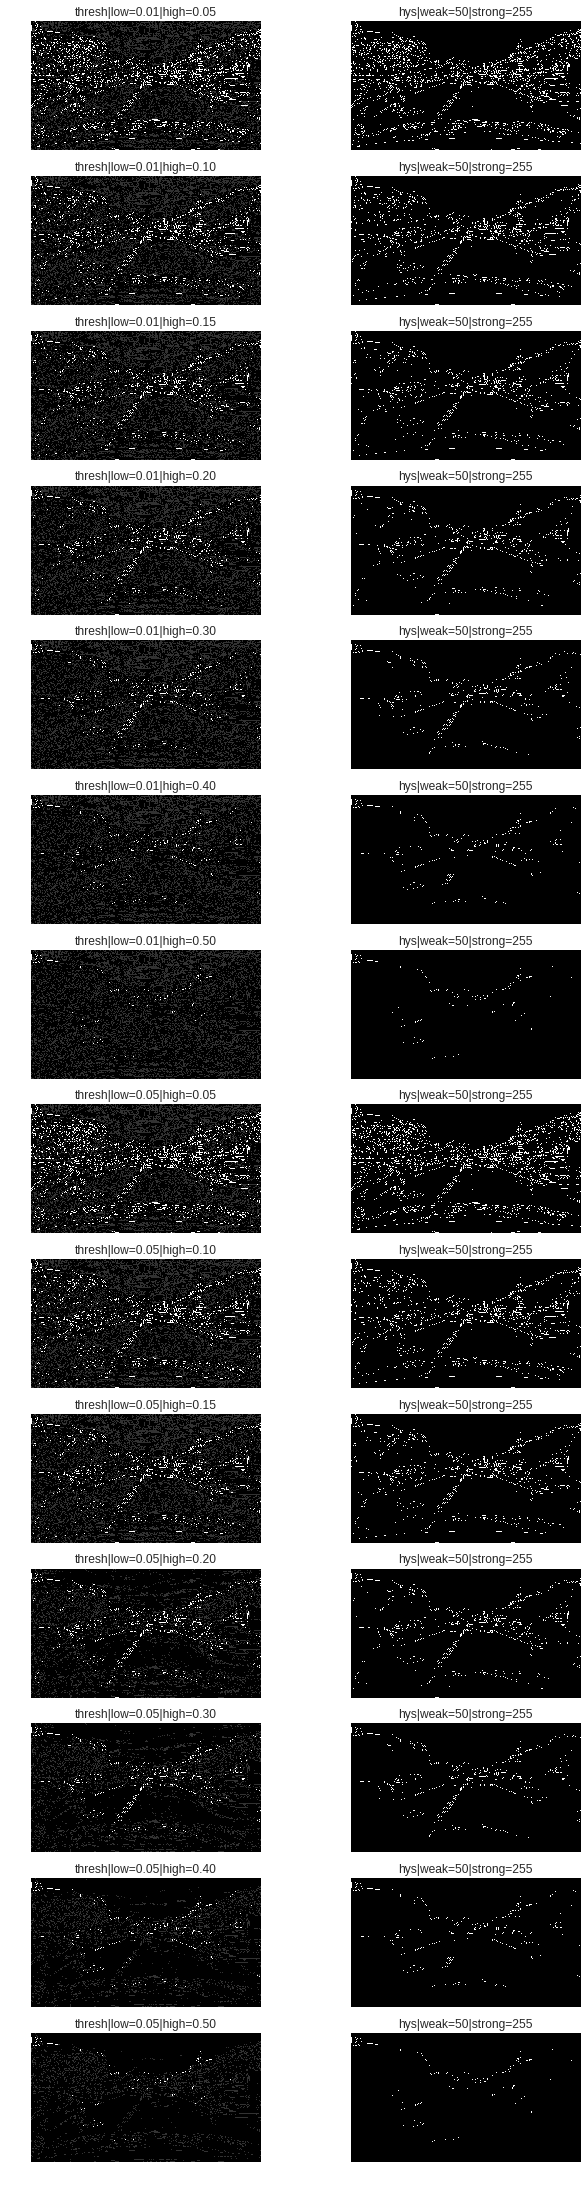

In [0]:


scale=5
R,C=np.array(gray.shape) / max(gray.shape)
lows= [0.01,0.05]
his=[0.05,0.1,0.15,0.2,0.3,0.4,0.5]
I,J = len(lows),len(his)
fig = plt.figure(figsize=(0.15*C*scale*I*J,R*scale*I*J))  
idx1=1
idx2=2
sigma=1
truncate=4
for i,low in enumerate(lows):
  for j,hi in enumerate(his):
    if low > hi: continue
    s = time.time() 
    thresh,weak,strong = threshold(nms, lowThresholdRatio=low, 
                                   highThresholdRatio=hi,
                                   strong=np.int32(255),
                                   weak=np.int32(50))
    strong,weak,hys = hysteresis_setup(thresh,strong,weak)
    hys=hysteresis(thresh.copy().astype(np.int16),
                   strong.astype(np.int16),
                   weak.astype(np.int16),
                   hys.astype(np.int16) )
    e = time.time()
    
    plt.subplot(I*J,2,idx1)
    plt.imshow(thresh,cmap='gray')
    plt.title('thresh|low=%1.2f|high=%1.2f'%(low,hi))
    plt.axis('off')
    idx1+=2
    
    plt.subplot(I*J,2,idx2)
    plt.imshow(hys,cmap='gray')
    plt.title('hys|weak=%i|strong=%i'%(weak[0],strong[0]))
    plt.axis('off')
    idx2+=2
    
    
    

The detected edges are similar, except if the high threshold is above `~0.2-0.3`. This means that the threshold is robust for this image. We could check a few other images and see if the same threshold is suitable.

# Laplacian of Gaussian
The Marr-Hildreth algorithm dates from 1980, six years before John Canny published his method. This method is summarized well in Gonzalez and Woods 10.2.  Although certain implementations of the Canny edge detection may compute the gradient in one way, we may want to consider another. One way is the Lapplacian of Gaussian. Gonzalez and Woods explain that one benefit to the Sobel operators is its tuneable parameter.

First can build intuition by looking at the following kernel is a 5x5 sample of the Laplacian of the Gaussian (ie mexican hat operator). See Fig 10.21 in Gonzalez and Woods, 3rd edition.



---



Text(0.5, 1.0, 'LoG 5x5 Kernel')

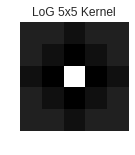

In [13]:
d2g = np.array([
                  [0,0,1,0,0],
                  [0,1,2,1,0],
                  [1,2,-16,2,1],
                  [0,1,2,1,0],
                  [0,0,1,0,0]
                ])
fig = plt.figure(figsize=(2,2))  
plt.imshow(d2g)
plt.axis('off')
plt.title('LoG 5x5 Kernel')

Text(0, 0.5, '(Negative) kernel intensity ')

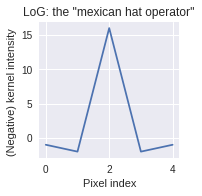

In [15]:
fig = plt.figure(figsize=(2.5,2.5))
pd.Series(-d2g[2]).plot(title='LoG: the "mexican hat operator"')
plt.xlabel('Pixel index')
plt.ylabel('(Negative) kernel intensity ')


Since the LoG kernel has smoothing from the Guassian and the second derivative from the Laplacian, we simply can either convolute the raw gray image with the 5x5 LoG kernel, or do two separate steps. One advantage of separate steps is that we can visualize the smoothing image If we want, we could use the kernel size of the cv2.Laplacian and the kernel type (default Sobel) as hyper parameters.

(-0.5, 1279.5, 719.5, -0.5)

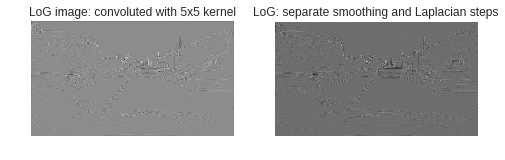

In [0]:
plt.subplot(121)
log5x5 = scipy.signal.convolve2d(gray,d2g)
plt.imshow(log5x5,cmap='gray')
plt.title('LoG image: convoluted with 5x5 kernel')
plt.axis('off')

plt.subplot(122)
log = cv2.Laplacian(smooth, cv2.CV_64F)
plt.imshow(log,cmap='gray')
plt.title('LoG: separate smoothing and Laplacian steps')
plt.axis('off')


The LoG convluted image is difficult to interpret, but it contains the information we need to detect the edges. First we find the range in a 3x3 window. This actually gets us quite far. The code below works in a vectorized way through `np.ufunc.reduce` by calculating the min and max in a 3x3 window around each pixel. The difference of these shows edges.

(-0.5, 1277.5, 717.5, -0.5)

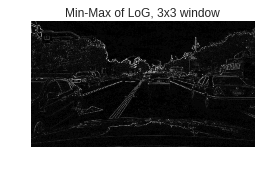

In [0]:
img=log
rows, cols = img.shape[:2]
min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                 for r in range(3) for c in range(3)))
max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                 for r in range(3) for c in range(3)))

# scale
value_scale = 255. / max(1., img.max() - img.min())
values = value_scale * (max_map - min_map)

fig = plt.figure(figsize=(4,4))
plt.imshow(max_map - min_map,cmap='gray')
plt.title('Min-Max of LoG, 3x3 window')
plt.axis('off')


We know that at an edge the second derivative should cross zero. We can find where this happens in vectorized form.

In [0]:
pos_img = 0 < img[1:rows-1, 1:cols-1] # laplacian positive
neg_min = min_map < 0 # value below zero in 3x3 window
pos_max = 0 < max_map # value above zero in 3x3 window
pos_max[pos_img] = 0 # bring max values to zero where laplacian positive
zero_cross = np.logical_or(neg_min,pos_max)

We can check for zero crossings and clean up the image a bit. If there is no zero crossing, then we set the pixel to zero (some or all may already be near zero already)

(-0.5, 1277.5, 717.5, -0.5)

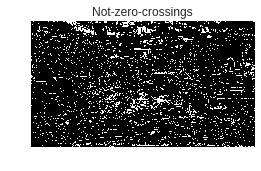

In [0]:
fig = plt.figure(figsize=(4,4))
plt.imshow(~zero_cross,cmap='gray')
plt.title('Not-zero-crossings')
plt.axis('off')

Text(0.5, 0, 'Pixel intensity')

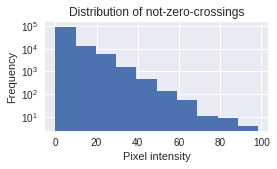

In [0]:
fig = plt.figure(figsize=(4,2))
pd.Series(pd.Series(values[~zero_cross])).plot(
  kind='hist',
  title='Distribution of not-zero-crossings',
  logy=True)
plt.xlabel('Pixel intensity')

Text(0.5, 1.0, 'Zero-crossing corrected')

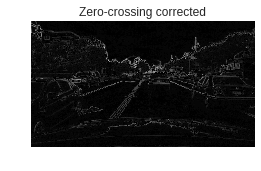

In [0]:
fig = plt.figure(figsize=(4,4))
values[~zero_cross] = 0.
log_img = values.astype(np.uint8)
plt.imshow(log_img,cmap='gray')
plt.axis('off')
plt.title('Zero-crossing corrected')

We can wrap this LoG up and add in some thresholding and padding (to keep return the image to the original dimensions)

In [0]:
import scipy.misc

def laplace_of_gaussian_wrapper(smooth, pad=True):
    """
    credit: # https://stackoverflow.com/questions/22050199/
    python-implementation-of-the-laplacian-of-gaussian-edge-detection
    
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param pad:      flag to pad output, keeping input image size
    """
    assert len(smooth.shape) == 2
    img = cv2.Laplacian(smooth, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = np.logical_or(neg_min,pos_max)
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[~zero_cross] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, 
                         mode='constant', constant_values=0)
    return log_img



Before we used Sobel filter and computed the magnitude and angle of the gradients. However, the Laplacian only gave intensity information, not direction.
 Therefore, at this point we can't do non-maximum supression, since we don't have gradient directions. However, we can do double thresholding and hysteresis as in Canny. Below we use the same smoothed image and compare Canny-with-Sobel-etc with our custom LoG side-by-side.



Text(0.5, 1.0, 'LoG')

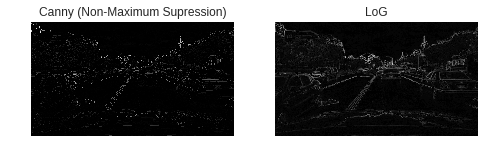

In [0]:
sigma=1
truncate=4
smooth = scipy.ndimage.filters.gaussian_filter(gray,sigma,truncate=truncate)

G, theta = sobel_filters(smooth)
img,angle,M,N,Z=non_max_suppression_setup(G,theta)
nms = non_max_suppression(img.astype(np.float64),
                          angle.astype(np.float64),
                          Z.astype(np.float64))

plt.subplot(121)
plt.imshow(nms,cmap='gray')
plt.axis('off')
plt.title('Canny (Non-Maximum Supression)')

plt.subplot(122)
log_wrapper = laplace_of_gaussian_wrapper(smooth, pad=True) 
plt.imshow(log_wrapper,cmap='gray')
plt.axis('off')
plt.title('LoG')

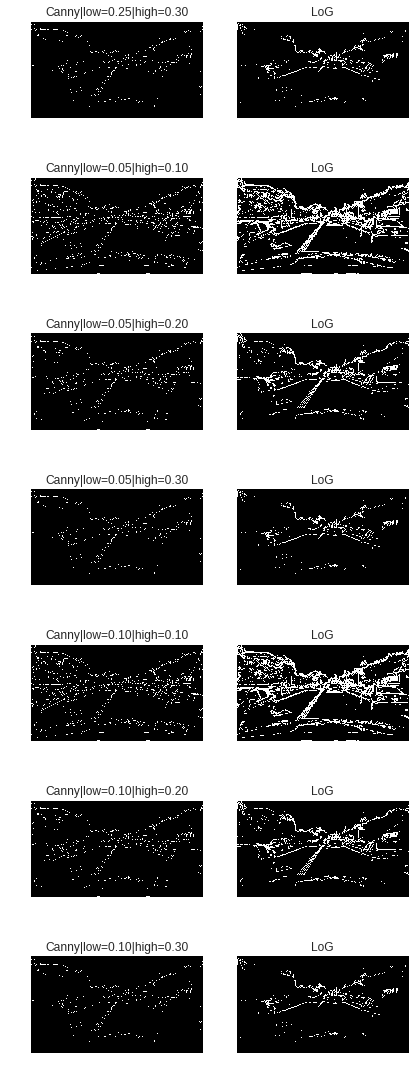

In [0]:
scale=5
R,C=np.array(gray.shape) / max(gray.shape)
lows= [0.25,0.05,0.1]
his=[0.1,0.2,0.3]
I,J = len(lows),len(his)
fig = plt.figure(figsize=(0.15*C*scale*I*J,R*scale*I*J))  
idx1=1
idx2=2
sigma=1
truncate=4
for i,low in enumerate(lows):
  for j,hi in enumerate(his):
    if low > hi: continue
    
    plt.subplot(I*J,2,idx1)
    thresh,weak,strong = threshold(nms, 
                                   lowThresholdRatio=low, 
                                   highThresholdRatio=hi,
                                   strong=np.int32(255),
                                   weak=np.int32(50))
    strong,weak,hys = hysteresis_setup(thresh,strong,weak)
    hys=hysteresis(thresh.copy().astype(np.int16),
                   strong.astype(np.int16),
                   weak.astype(np.int16),
                   hys.astype(np.int16) )
    
    plt.imshow(hys,cmap='gray')
    plt.title('Canny|low=%1.2f|high=%1.2f'%(low,hi))
    plt.axis('off')
    idx1+=2
    
    plt.subplot(I*J,2,idx2)
    thresh,weak,strong = threshold(log_wrapper, 
                                   lowThresholdRatio=low, 
                                   highThresholdRatio=hi,
                                   strong=np.int32(255),
                                   weak=np.int32(50))
    strong,weak,hys = hysteresis_setup(thresh,strong,weak)
    hys=hysteresis(thresh.copy().astype(np.int16),
                   strong.astype(np.int16),
                   weak.astype(np.int16),
                   hys.astype(np.int16) )
    plt.imshow(hys,cmap='gray')
    plt.title('LoG')
    plt.axis('off')
    idx2+=2
    
    
    

# Conclusion

Each step of Canny edge detection can be visualized. Understanding what is going on at each step has allowed us to swap out gradient computation (direction and magnitude with Sorbel kernels) and Non-Maximum Supression with a Laplacian of Gaussian approach.   


Canny/Sobel/Non-Maximum Supression edge detection has choices for  
1. initial smooting  
2. choise of kernels to compute gradient (they have to yield the magnitude and direction   
3. two parameters for double thresholding with hysteresis.  




Our LoG method has  
1. initial choise of smoothing  
2. implicit kernel choise in implementation of Laplacian (eg Prewitt or Sobel)
3. two parameters for double thresholding with hysteresis.  

No one says that we have to choose only one method. We could look for consensus over a range of cutoffs and methods. In this image the road markings sometimes appear, and sometimes do not. With LoG the road markings go away at a `0.3` high threshold cutoff. With Canny, the road markings are not as bold and pronounced. The next step for edge detection is the Hough transformation. Although I will use an implementaiton of Canny Edge detection in opencv from now on, future work could look at how the Hough transform performs different depending on the Canny/LoG edge detection.